In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import operator
from functools import reduce

In [12]:
def read_stock_price(file_name = 'DailyClosing-SelectedIndices-2019to2023.xlsx'):    
    # read in stock price of all the indices from the 1-16th sheets from xlsx file, and the content start from the 4th row with 3rd row as header
    series = pd.read_excel(file_name, sheet_name=None,  skiprows=2)
    # delete the first and last sheet
    series.pop('Indices')
    series.pop('Sheet2')
    return series

In [13]:
# compute the directional change of the stock price series, input is the threshold of the directional change
# some parts of the init and end of the series may not be included in the directional change events
def compute_directional_change(series, threshold):
    dc_events = {}
    for sheet_name, data in series.items():
        prices = data['Close']
        max_index = 0
        min_index = 0
        # format: start index, end index, direction(1 for up, -1 for down, 2/-2 for overshoot)
        directional_change_events = []
        # state: init, up, down
        last_state = 'init'
    
        for i, p in enumerate(prices[1:]):
            if last_state == 'up':
                if p <= prices[max_index] * (1 - threshold):
                    last_state = 'down'
                    if max_index > directional_change_events[-1][1]:
                        directional_change_events.append((directional_change_events[-1][1], max_index, 2))
                    directional_change_events.append((max_index, i, -1))
                    max_index = i
                    min_index = i
                if p > prices[max_index]:
                    max_index = i
                if p < prices[min_index]:
                    min_index = i
            elif last_state == 'down':
                if p >= prices[min_index] * (1 + threshold):
                    last_state = 'up'
                    if min_index > directional_change_events[-1][1]:
                        directional_change_events.append((directional_change_events[-1][1], min_index, -2))
                    directional_change_events.append((min_index, i, 1))
                    max_index = i
                    min_index = i
                if p > prices[max_index]:
                    max_index = i
                if p < prices[min_index]:
                    min_index = i
            elif last_state == 'init':
                if p >= prices[min_index] * (1 + threshold):
                    last_state = 'up'
                    directional_change_events.append((min_index, i, 1))
                    max_index = i
                    min_index = i
                elif p <= prices[max_index] * (1 - threshold):
                    last_state = 'down'
                    directional_change_events.append((max_index, i, -1))
                    max_index = i
                    min_index = i
                else:
                    if p > prices[max_index]:
                        max_index = i
                    elif p < prices[min_index]:
                        min_index = i 
        dc_events[sheet_name] = directional_change_events

    # draw the picture of the stock price series changing over time, all the indices colored in different color in one picture with sheet_name as legend
    plt.figure(figsize=(25, 16))
    colors = plt.cm.tab20(np.linspace(0, 1, 16))
    for i, (sheet_name, data) in enumerate(series.items()):
        plt.plot(data['Date'], data['Close'], label=sheet_name, color=colors[i])
        # Calculate the slope of the line at the last point
        y_diff = data['Close'].iloc[-1] - data['Close'].iloc[-2]
        x_diff = data['Date'].iloc[-1] - data['Date'].iloc[-2]
        slope = y_diff / x_diff.total_seconds()
        # Adjust the position of the annotation based on the slope
        va = 'bottom' if slope > 0 else 'top'
        plt.annotate(sheet_name, (data['Date'].iloc[-1], data['Close'].iloc[-1]), verticalalignment=va, color=colors[i])
        
        # plot the directional change events, use arrow to indicate the direction, red for up and green for down
        # if overshoots, use the same color as the last direction
        for k, event in enumerate(dc_events[sheet_name]):
            arrow_color = 'red' if event[2] > 0 else 'green'
            # plot the points of the directional change events, the color of the end point is the same as the closing price curve
            plt.scatter(data['Date'].iloc[event[0]], data['Close'].iloc[event[0]], color=colors[i])
            plt.scatter(data['Date'].iloc[event[1]], data['Close'].iloc[event[1]], color=colors[i])
            # plot the arrow of the directional change events
            plt.annotate('', xy=(data['Date'].iloc[event[1]], data['Close'].iloc[event[1]]), xytext=(data['Date'].iloc[event[0]], data['Close'].iloc[event[0]]), arrowprops=dict(arrowstyle='->', color=arrow_color))
    
    # set the coordinates of the x-axis and y-axis
    plt.xlim(series['DJI']['Date'].iloc[0], series['DJI']['Date'].iloc[-1])
    plt.ylim(0, 75000)    
    # set the x-axis label as date, y-axis label as close price, and title as Daily Closing of Selected Indices: from 2019 to 2023
    plt.xlabel('Date', fontsize='large')
    plt.ylabel('Close Price', fontsize='large')
    plt.title('Daily Closing of Selected Indices: from 2019 to 2023 & Directional Changes(red for up and overshoots, green for down and overshoots)', fontsize='large')
    # set the legend and make it larger
    plt.legend(loc='center left', bbox_to_anchor=(0, 0.8), fontsize='large', title='Indices', title_fontsize='large')
    # save the picture and set the resolution to be high
    plt.savefig('DailyClosing&DirectionChanges.png', bbox_inches='tight', dpi=600)
    return dc_events

In [14]:
def compute_risk(series, dc_events):
    risks = {}
    # compute the VaR and CVaR of the stock price series
    for sheet_name, data in series.items():
        prices = data['Close']
        # compute the return of the period
        period_return = prices.iloc[-1] / prices.iloc[0] - 1
        # compute the daily return of the stock price series
        daily_return = prices.pct_change()
        # compute the standard deviation of the daily return
        std_daily_return = daily_return.std()
        # compute the VaR and CVaR of the stock price series
        VaR = daily_return.quantile(0.05)
        CVaR = daily_return[daily_return < VaR].mean()
        # compute the frequency of the directional change NDC
        NDC = sum(1 for e in dc_events[sheet_name] if abs(e[2]) == 1) - 1
        # compute the potential for profits
        PFP = reduce(operator.mul, [data['Close'][e[1]] / data['Close'][e[0]] for e in dc_events[sheet_name] if e[2] > 0])
        # compute the ratio of positive overshoots and averaged ratio of overshoots
        ratio_positive_overshoots = sum(1 for e in dc_events[sheet_name] if e[2] == 2) / sum(1 for e in dc_events[sheet_name] if e[2] == 1)
        averaged_overshoots_gain = np.mean([data['Close'][e[1]] / data['Close'][e[0]] for e in dc_events[sheet_name] if e[2] == 2])
        # the first is the period return, the 2cd-4th are risk measures under time series, the 5th-8th are risk measures under directional change events
        risks[sheet_name] = (period_return, std_daily_return, VaR, CVaR, NDC, PFP, ratio_positive_overshoots, averaged_overshoots_gain)
    
    # plot 6 pictures, one for each risk measure
    fig, axs = plt.subplots(2, 3, figsize=(25, 16))
    markers = ['o', 'x', '+', 'v', '^', '<', '>', 's', 'd', 'p', 'P', '*', 'h', 'H', 'X', '|']
    colors = plt.cm.tab20(np.linspace(0, 1, 16))
    risk_measures = ['Standard Deviation of Returns', '-1*VaR', '-1*CVaR', 'NDC', 'Potential for Profits', 'Ratio of Positive Overshoots', 'Averaged Ratio of Positive Overshoots']
    for i in range(6):
        if i != 5:
            # the (i+1 th risks, period return) scatter plot for all the indices(markets) in the same subplot
            # each index is colored in different color and has different markers, annotate the index name, and set all things large
            # change the y-axis to percentage
            # avoid the overlap of the annotations
            for j, (sheet_name, risk) in enumerate(risks.items()):
                axs[i//3, i%3].scatter(abs(risk[i+1]), risk[0], label=sheet_name, color=colors[j], marker=markers[j], s=200)
                axs[i//3, i%3].annotate(sheet_name, (abs(risk[i+1]), risk[0]), fontsize='large', color=colors[j], xytext=(0, 10), textcoords='offset points', ha='center')
                axs[i//3, i%3].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
            # set the x-axis label as the risk measure, y-axis label as period return, and title: Risk Measure vs Period Return
            axs[i//3, i%3].set_xlabel(risk_measures[i], fontsize='large')
            axs[i//3, i%3].set_ylabel('Period Return', fontsize='large')
            axs[i//3, i%3].set_title(f'{risk_measures[i]} vs Period Return', fontsize='large')
        else:
            # plot the rectangle graph for the last two as well as their multiplication on the same subplot
            rpo_aog_mul = [[risk[6] for risk in risks.values()], [risk[7] for risk in risks.values()], [risk[6]*risk[7] for risk in risks.values()]]
            for i, (sheet_name, risk) in enumerate(risks.items()):
                axs[1, 2].scatter(['#Positive Overshoots/#Positive DC', 'Averaged Overshoots Gains', 'Multiplication'], [rpo_aog_mul[j][i] for j in range(3)], label=sheet_name, color=colors[i], marker=markers[i], s=50)
            # set legend, x-axis label, y-axis label, and title
            axs[1, 2].legend(loc='center', bbox_to_anchor=(0.5, 0.2), ncol=2)
            axs[1, 2].set_xlabel('Risk Measure', fontsize='large')
            axs[1, 2].set_ylabel('Value', fontsize='large')
            axs[1, 2].set_title('Ratio of Positive Overshoots, Averaged Overshoots Gains, and their Multiplication')
    # save the picture and set the resolution to be high
    plt.savefig('RiskMeasures&PeriodReturn.png', bbox_inches='tight', dpi=600)
    return risks

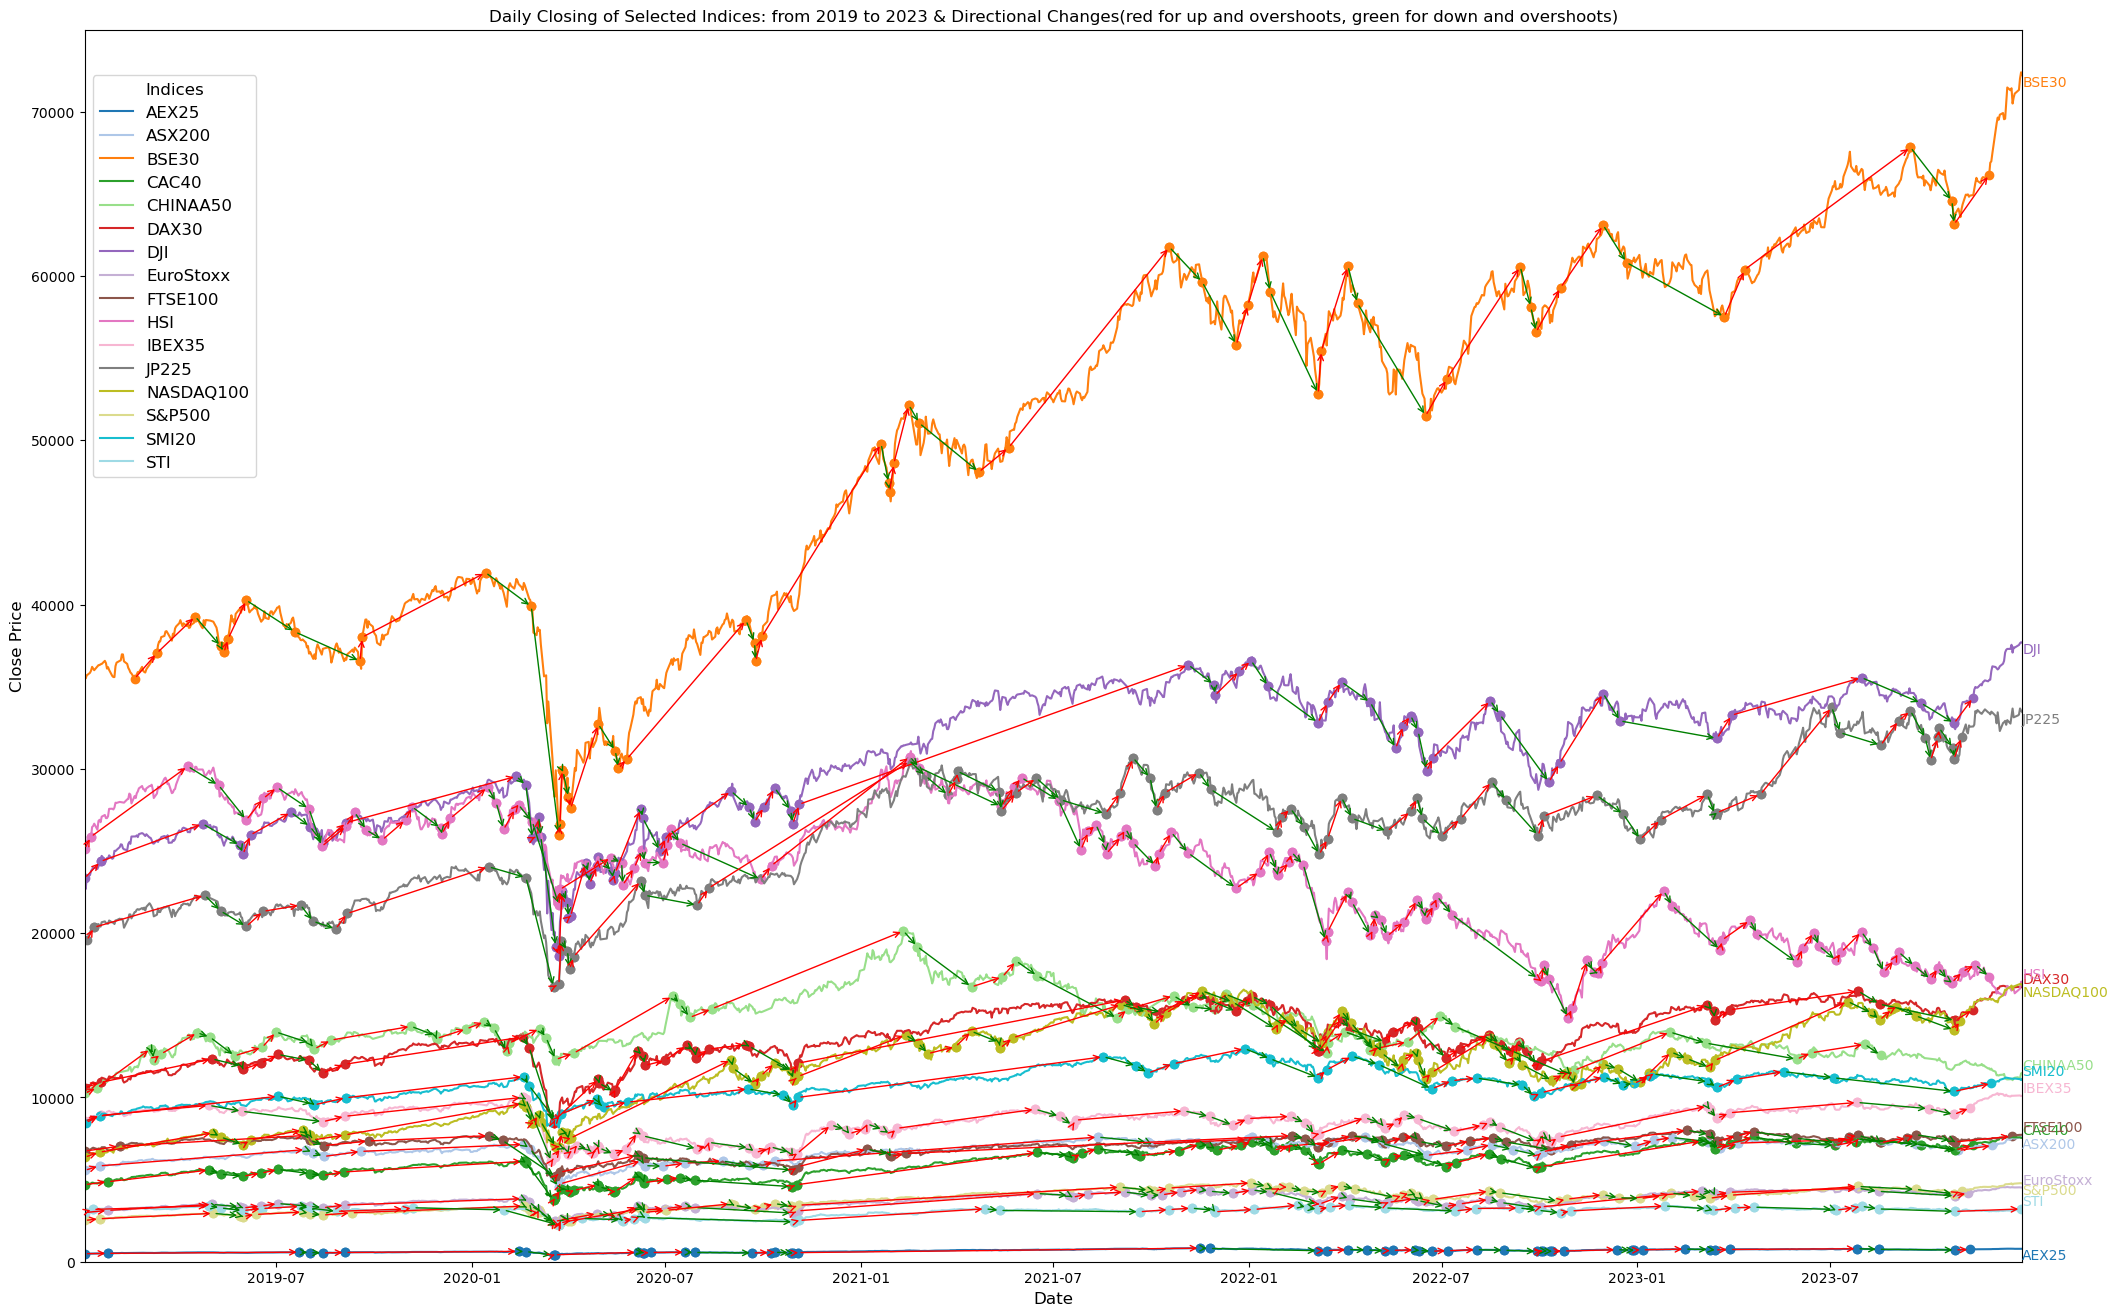

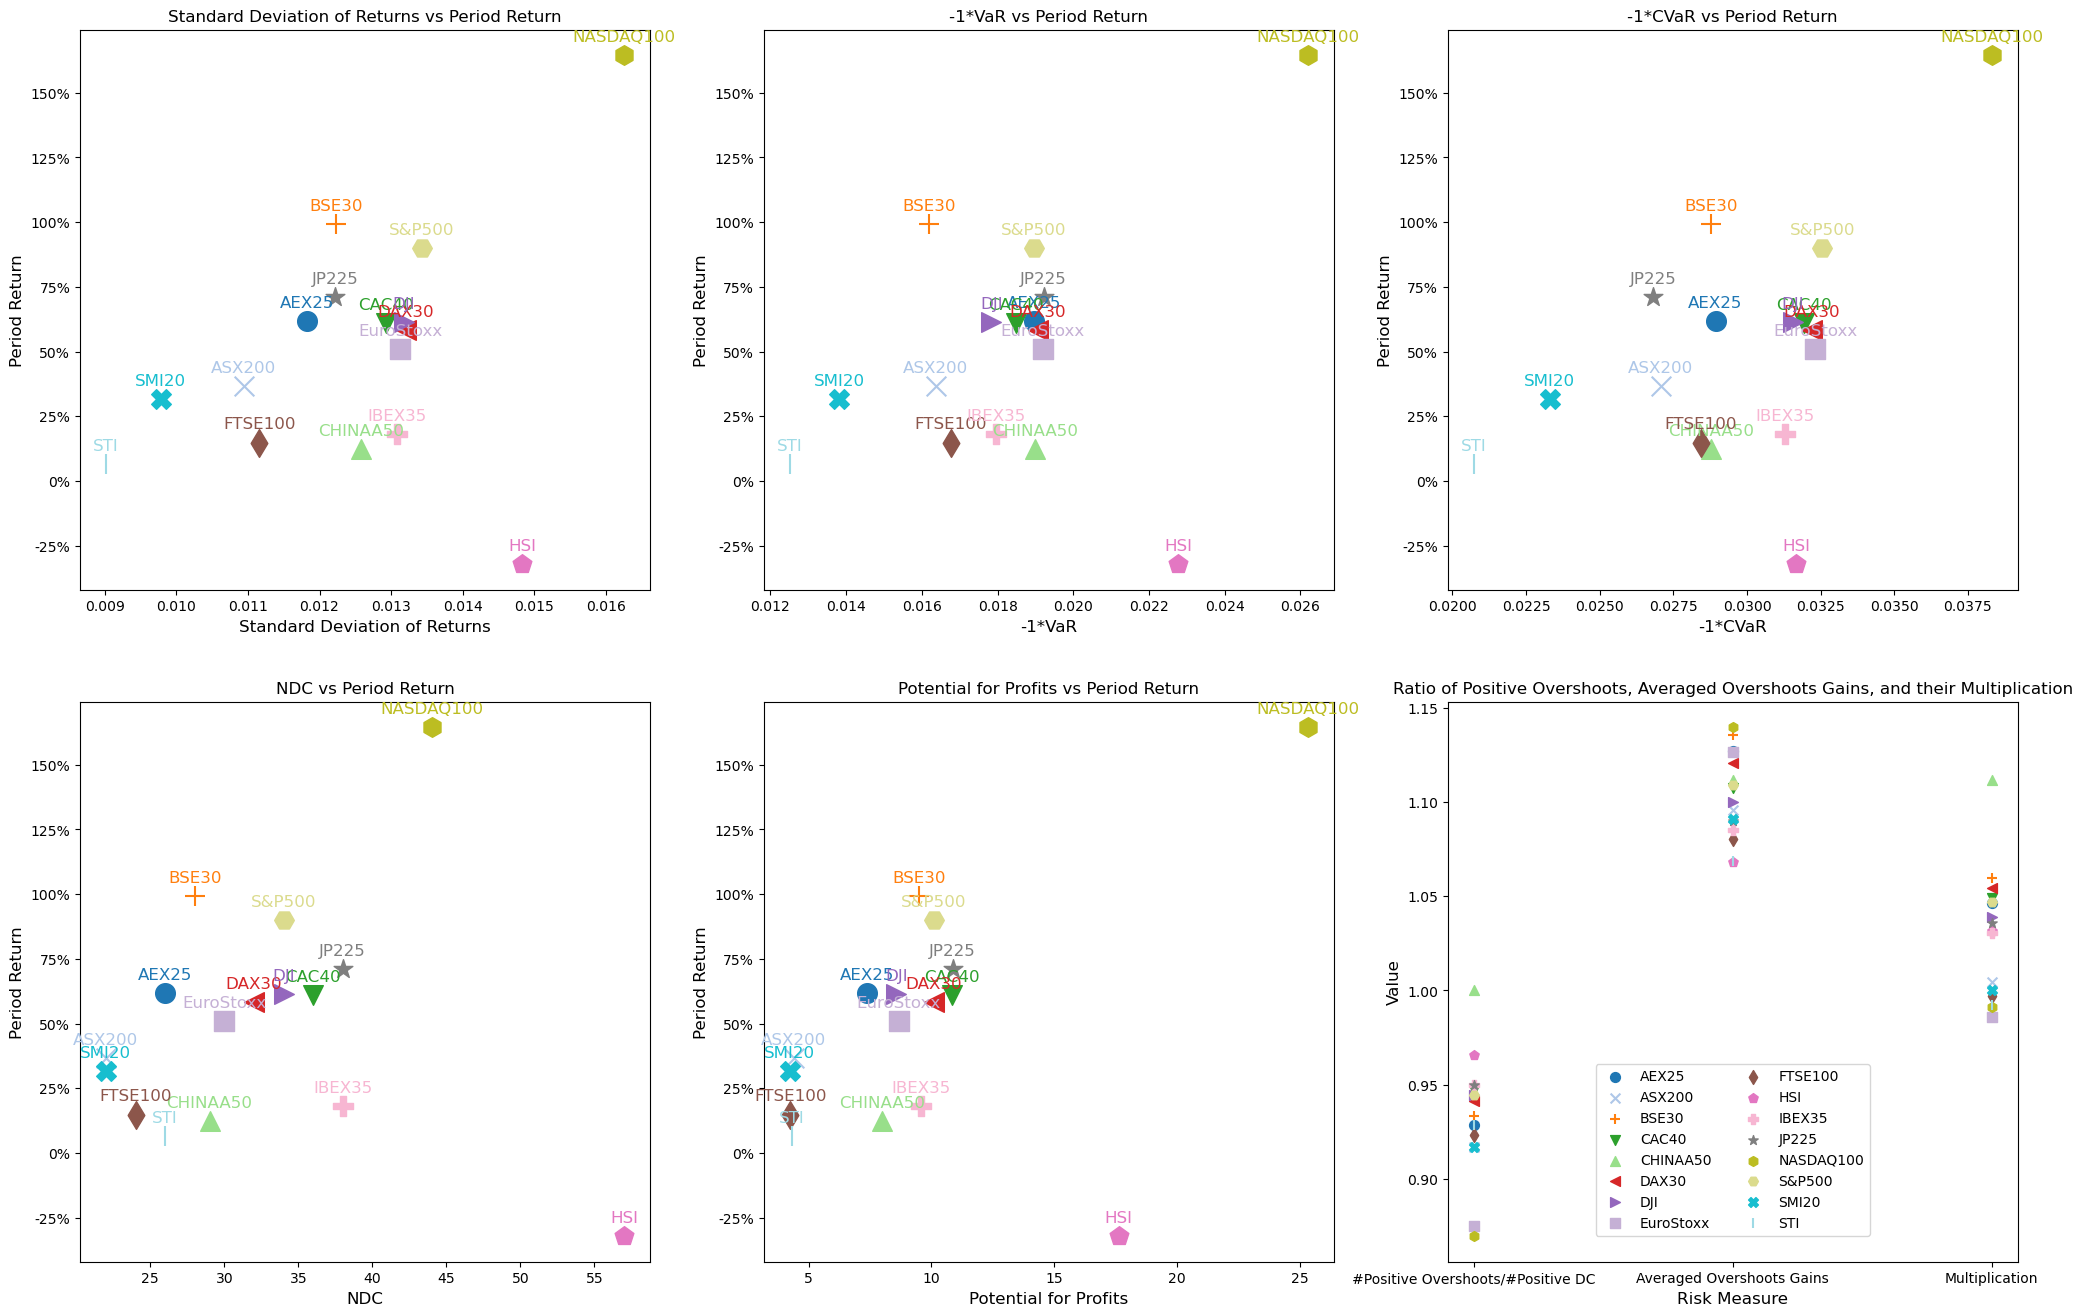

In [15]:
if __name__ == '__main__':
    series = read_stock_price()
    # compute the directional change of the stock price series with threshold 0.05
    dc_events = compute_directional_change(series, 0.05)
    # compute the risk of the stock price series
    risks = compute_risk(series, dc_events)